In [5]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import DLinear
from neuralforecast.utils import AirPassengersPanel
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.datasets import ETTh1Dataset
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping

# DLinear

In [6]:
def train_dlinear(df):
    """Train a DLinear model using the NeuralForecast library."""
    model = DLinear(
        h=12,                # Forecast horizon
        input_size=24,       # Look-back window
        moving_avg_window=13,  # Must be uneven for centered decomposition
        max_steps=1000
    )
    nf = NeuralForecast(models=[model], freq='M')
    nf.fit(df=df)
    return nf

# Load data and fit
y_df = AirPassengersPanel
nf_dlinear = train_dlinear(y_df)

# Forecast
forecast_dlinear = nf_dlinear.predict()

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | linear_trend  | Linear        | 300    | train
5 | linear_season | Linear        | 300    | train
--------------------------------------------------------
600       Trainable params
0         Non-trainable params
600       Total params
0.002     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1000` reached.
/Users/ben/anaconda3/envs/ml_timeseries/lib/python3.12/site-packages/utilsforecast/processing.py:378: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/ben/anaconda3/envs/ml_timeseries/lib/python3.12/site-packages/utilsforecast/processing.py:434: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

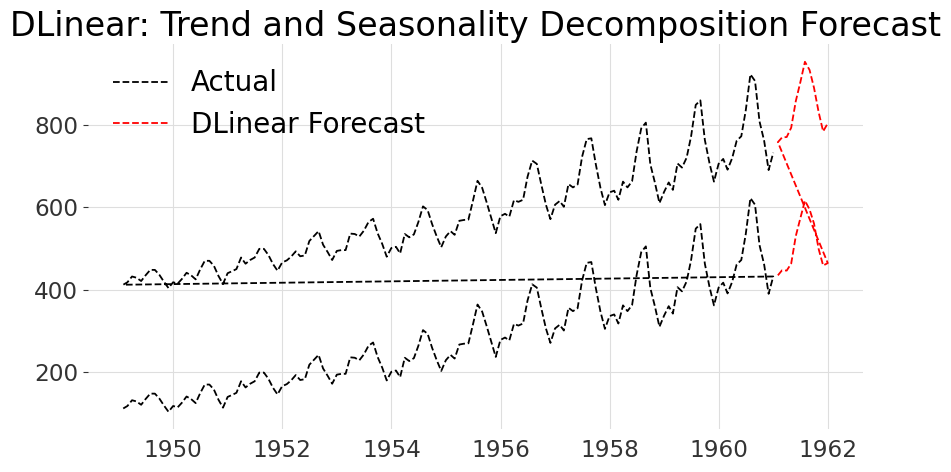

In [10]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y_df['ds'], y_df['y'], label='Actual')
plt.plot(forecast_dlinear['ds'], forecast_dlinear['DLinear'], label='DLinear Forecast', color='red')
plt.title("DLinear: Trend and Seasonality Decomposition Forecast")
plt.legend()
plt.show()

# TSMixer

In [12]:
def train_tsmixer(series):
    """Train a TSMixer model with scaling and early stopping."""
    # Split 70/30 and scale
    train, val = series.split_after(0.7)
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)

    # Define early stopping to prevent overfitting
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=1e-4,
        mode='min'
    )

    model = TSMixerModel(
        input_chunk_length=512,
        output_chunk_length=96,
        norm_type='LayerNorm',
        pl_trainer_kwargs={"callbacks": [early_stopper]}
    )

    model.fit(series=train_scaled, val_series=val_scaled, epochs=50)
    return model, scaler, train_scaled, val


# Load multivariate data (Oil Temperature and others)
etth1_series = ETTh1Dataset().load()
# Capture the training data and validation set needed for prediction and plotting
model_tsm, tsm_scaler, train_scaled, val = train_tsmixer(etth1_series)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 49.2 K | train
6 | feature_mixing_hist | _FeatureMixing   | 17.5 K | train
7 | conditional_mixer   | ModuleList       | 84.4 K | train
8 | fc_out              | Linear           | 455    | train
-----------------------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
45        Modules in train

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [ ]:
# Generate the forecast in the scaled space
# TSMixer is channel-dependent, so it uses the training history to predict
pred_scaled = model_tsm.predict(
    n=96, 
    series=train_scaled
)

# Inverse transform to return to original temperature units
pred_unscaled = tsm_scaler.inverse_transform(pred_scaled)


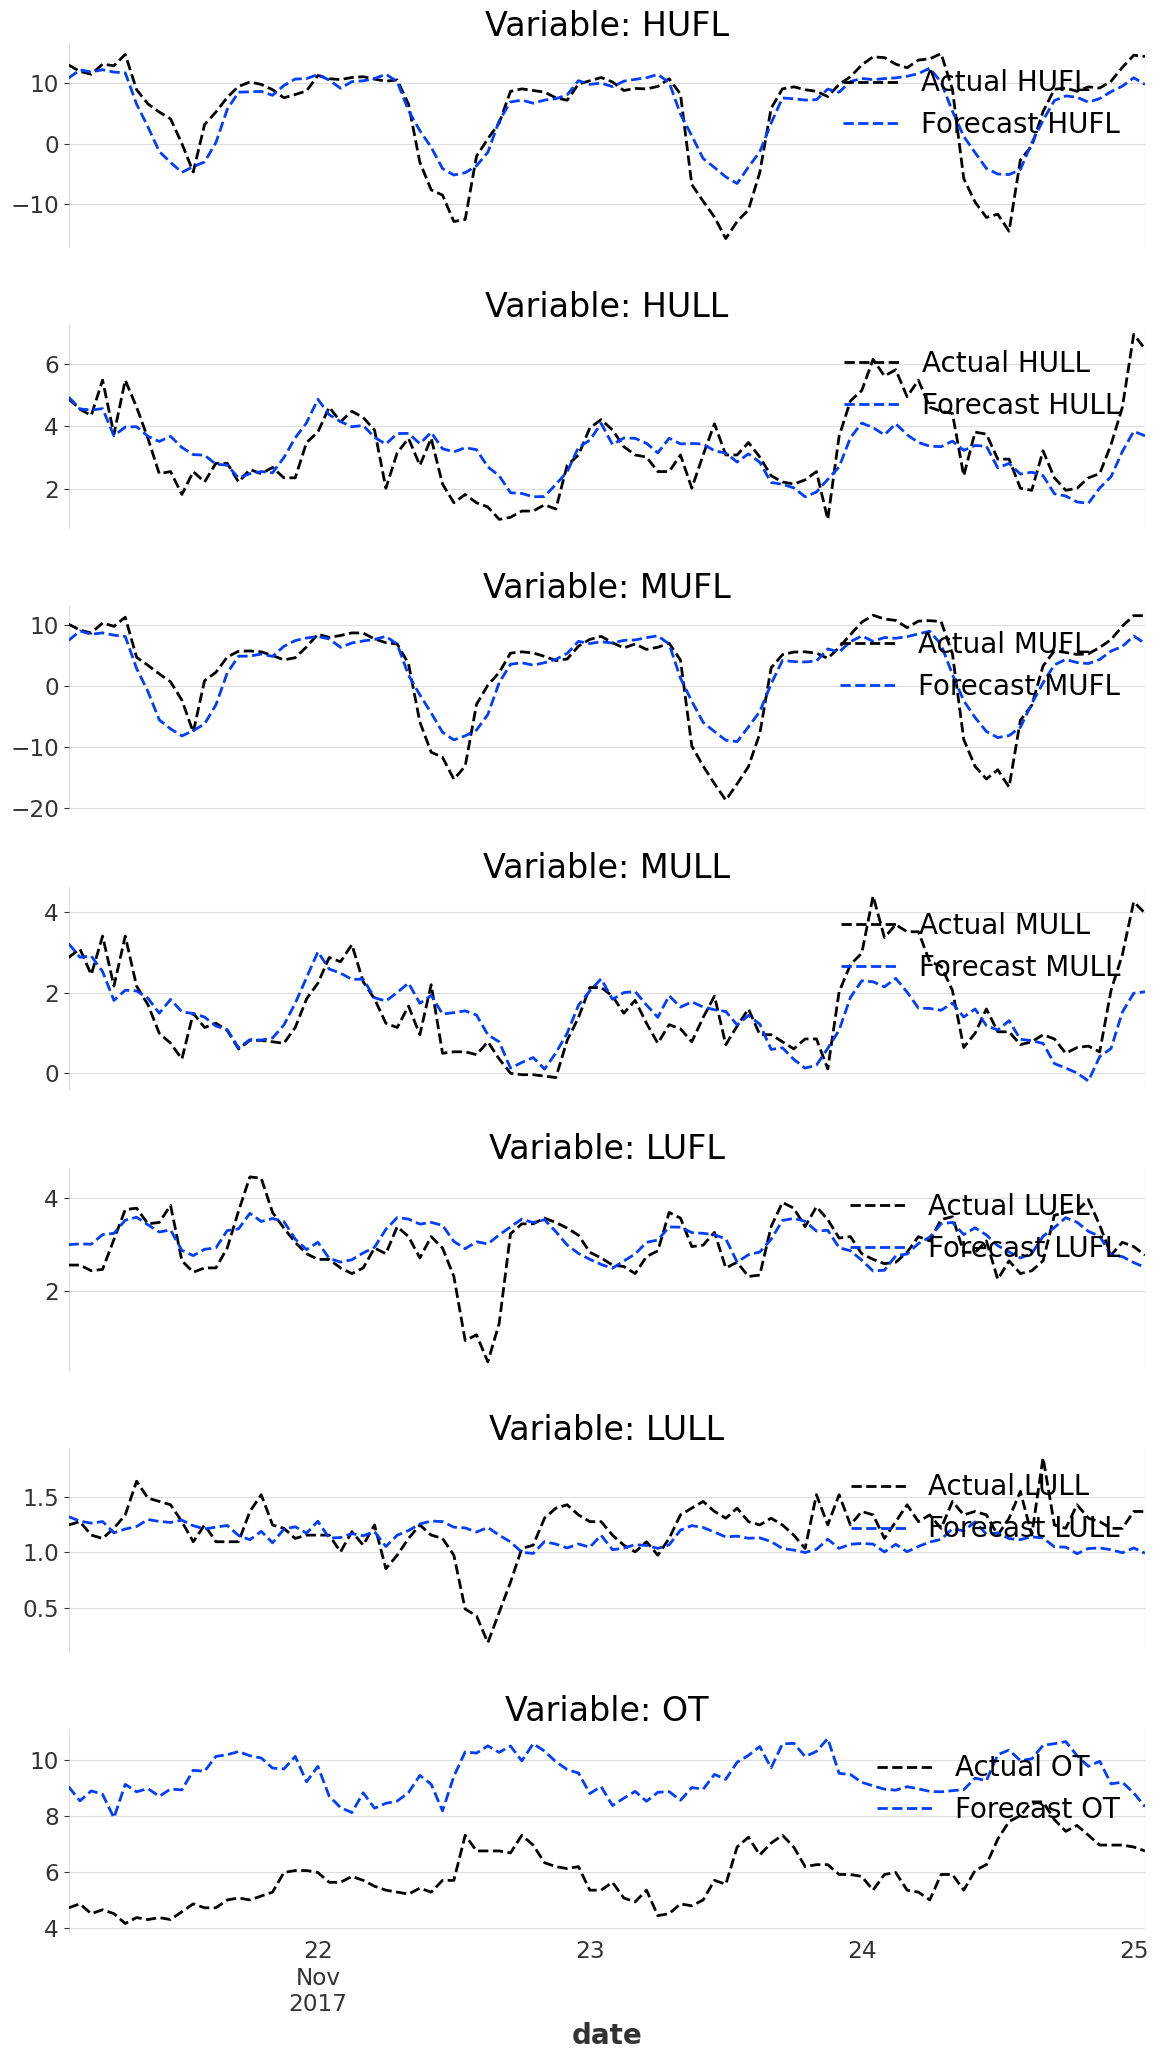

In [17]:
import matplotlib.pyplot as plt
# Visualize the results
def plot_multivariate_results(val_actual, forecast):
    """Create individual subplots for each variable in the ETTh1 dataset."""
    components = val_actual.components
    num_components = len(components)
    
    fig, axes = plt.subplots(
        nrows=num_components, 
        ncols=1, 
        figsize=(12, 3 * num_components), 
        sharex=True
    )
    
    for i, col in enumerate(components):
        # Select the specific component for both actual and forecast
        val_actual[col].plot(ax=axes[i], label=f'Actual {col}')
        forecast[col].plot(ax=axes[i], label=f'Forecast {col}', lw=2)
        axes[i].set_title(f'Variable: {col}')
        axes[i].legend(loc='upper right')
        
    plt.tight_layout()
    plt.show()

# Execution using the captured variables
plot_multivariate_results(val[:96], pred_unscaled)